In [153]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [154]:
def calculate_RSI(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [155]:
# Download Stock Data
stock_symbol = 'SPY'
data = yf.download(stock_symbol, start='2020-01-01', end='2024-08-05')
vix = yf.download('^VIX', start='2020-01-01', end='2024-08-05')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [165]:
# Get acutal data
a_data = yf.download(stock_symbol, start='2024-08-06', end='2024-08-31')
a_data.dropna(inplace=True)
a_data = a_data['Close']
a_data = pd.DataFrame(a_data)[:10]

[*********************100%***********************]  1 of 1 completed


In [166]:
# Prepare Data
short_window = 12
long_window = 26
signal_window = 9
data['RSI'] = calculate_RSI(data, 9)
data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
data['VIX'] = vix['Close']
data

/tmp/ipykernel_780/118688501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI'] = calculate_RSI(data, 10)
/tmp/ipykernel_780/118688501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
/tmp/ipykernel_780/118688501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,Close,Volume,MACD,RSI,VIX,EMA12,EMA26,Signal_Line
Date,,,,,,,,
2020-01-15,328.190002,72056600,0.000000,NaN,12.420000,328.190002,328.190002,0.000000
2020-01-16,330.920013,54050300,0.217779,NaN,12.320000,328.610004,328.392225,0.043556
2020-01-17,331.950012,95846000,0.468086,NaN,12.100000,329.123852,328.655765,0.128462
2020-01-21,331.299988,77742400,0.607008,NaN,12.850000,329.458642,328.851634,0.224171
2020-01-22,331.339996,48914900,0.712124,NaN,12.910000,329.748081,329.035957,0.321762
...,...,...,...,...,...,...,...,...
2024-07-29,544.760010,39515800,0.497057,32.328774,16.600000,548.691561,548.194503,3.006251
2024-07-30,542.000000,46853600,-0.073561,25.618682,17.690001,547.662090,547.735651,2.390288
2024-07-31,550.809998,65663400,0.183003,43.583853,16.360001,548.146383,547.963380,1.948831


In [176]:
# Select relevant features: Closing price, Volume, MACD, RSI, VIX
data = data[['Close', 'Volume', 'MACD', 'RSI', 'VIX']]

# Drop any NaN values that might exist
data.dropna(inplace=True)

# Prepare the dataset for multiple days ahead prediction
n_future_days = 10  # Predict the next 5 trading days
n_past_days = 60   # Use past 300 days to predict future

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

scaled_data

array([[0.30320845, 0.07499669, 0.71344673, 0.42621608, 0.06395594],
       [0.30630868, 0.13405929, 0.71251557, 0.46044268, 0.05124947],
       [0.28890649, 0.23891905, 0.6976154 , 0.24585448, 0.09854582],
       ...,
       [0.95890735, 0.10718832, 0.72548579, 0.40819032, 0.06353241],
       [0.93609436, 0.13662078, 0.7127722 , 0.37681355, 0.09501624],
       [0.90652522, 0.15401019, 0.67867073, 0.32931166, 0.16278412]])

In [ ]:
# Create the dataset with multiple future days
X_train = []
y_train = []
for i in range(n_past_days, len(scaled_data) - n_future_days):
    X_train.append(scaled_data[i - n_past_days:i])
    y_train.append(scaled_data[i:i + n_future_days, 0])  # Predict 'Close' for future days

X_train, y_train = np.array(X_train), np.array(y_train)

In [257]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(n_future_days))  # Output layer adjusted for future days

model.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
obj = model.fit(X_train, y_train, epochs=50, batch_size=8)
obj

Epoch 1/50
134/134 [==============================] - 4s 14ms/step - loss: 0.0248
Epoch 2/50
134/134 [==============================] - 2s 13ms/step - loss: 0.0015
Epoch 3/50
134/134 [==============================] - 2s 13ms/step - loss: 0.0014
Epoch 4/50
134/134 [==============================] - 2s 13ms/step - loss: 0.0014
Epoch 5/50
134/134 [==============================] - 2s 13ms/step - loss: 0.0013
Epoch 6/50
134/134 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 7/50
134/134 [==============================] - 2s 14ms/step - loss: 0.0012
Epoch 8/50
134/134 [==============================] - 2s 14ms/step - loss: 0.0011
Epoch 9/50
134/134 [==============================] - 2s 15ms/step - loss: 0.0011
Epoch 10/50
134/134 [==============================] - 2s 13ms/step - loss: 0.0014
Epoch 11/50
134/134 [==============================] - 2s 14ms/step - loss: 0.0011
Epoch 12/50
134/134 [==============================] - 2s 13ms/step - loss: 0.0011
Epoch 13/50
1

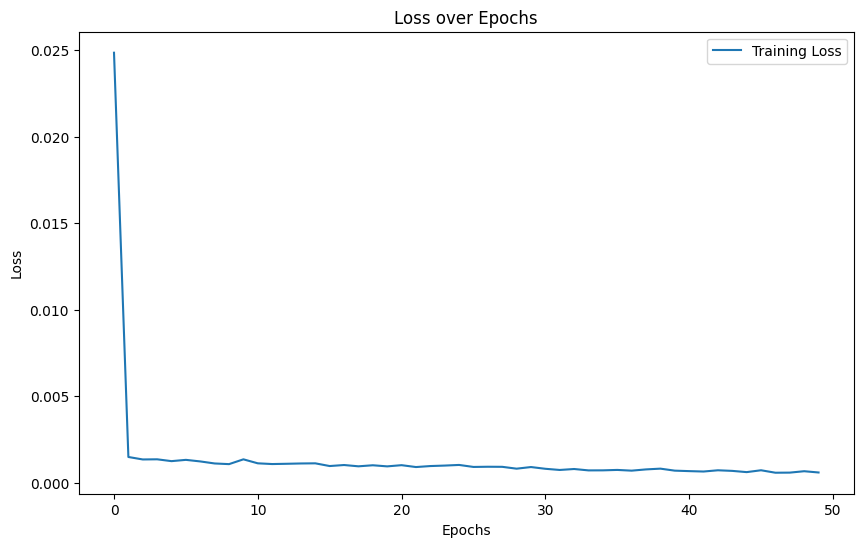

In [258]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(obj.history['loss'], label='Training Loss')

# If validation data was used, plot validation loss as well
if 'val_loss' in obj.history:
    plt.plot(obj.history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [259]:
# Predict the next few trading days
predictions = model.predict(X_train[-1].reshape(1, n_past_days, X_train.shape[2]))

# Flatten predictions and reshape to match the dimensions
predictions = predictions.flatten().reshape(-1, 1)

# Create an array of zeros for other features to inverse transform
dummy_array = np.zeros((n_future_days, scaled_data.shape[1] - 1))



1/1 [==============================] - 0s 399ms/step


In [260]:
# Concatenate and inverse transform
predicted_prices = scaler.inverse_transform(np.hstack((predictions, dummy_array)))[:,0]  # Only take 'Close' values
# len(predicted_prices)
# len(a_data)

# Assign predicted_prices to a_data['Pred']

a_data['Pred'] = predicted_prices
a_data['difference (%)'] = ((a_data['Pred'] - a_data['Close']) / a_data['Close']) * 100
# Print the DataFrame to check the assignment

a_data


,Close,Pred,difference (%)
Date,,,
2024-08-06,522.150024,548.062918,4.962730
2024-08-07,518.659973,546.323290,5.333613
2024-08-08,530.650024,547.073945,3.095057
2024-08-09,532.989990,550.962890,3.372089
2024-08-12,533.270020,548.188211,2.797493
2024-08-13,542.039978,546.240040,0.774862
2024-08-14,543.750000,547.350922,0.662239
2024-08-15,553.070007,548.804036,-0.771326
2024-08-16,554.309998,547.303479,-1.264007


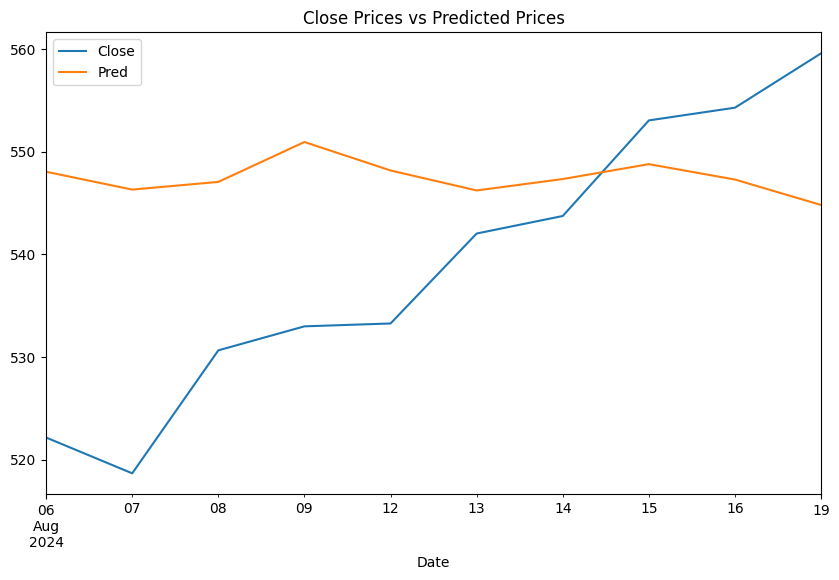

In [261]:
a_data.plot(y=['Close', 'Pred'], figsize=(10, 6), title='Close Prices vs Predicted Prices')
plt.show()